In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
%matplotlib inline

In [2]:
import copy

def get_perspective_matrix(image):

    src = np.float32([
        [10, 160],
        [100, 125],
        [200, 125],
        [230, 160], 
    ])
    
    #perspective1 = copy.copy(image)
    #perspective1 = cv2.circle(perspective1, (src[0, 0], src[0, 1]), 2, (255, 50, 25), -1)
    #perspective1 = cv2.circle(perspective1, (src[1, 0], src[1, 1]), 2, (255, 50, 25), -1)
    #perspective1 = cv2.circle(perspective1, (src[2, 0], src[2, 1]), 2, (255, 50, 25), -1)
    #perspective1 = cv2.circle(perspective1, (src[3, 0], src[3, 1]), 2, (255, 50, 25), -1)
    
    dst = np.float32([
        [10, 160],
        [10, 125],
        [230, 125],
        [230, 160]
    ])
    
    #plt.imshow(perspective1)
    #plt.show()
    
    #perspective2 = copy.copy(image)
    #perspective2 = cv2.circle(perspective2, (dst[0, 0], dst[0, 1]), 2, (0, 50, 250), -1)
    #perspective2 = cv2.circle(perspective2, (dst[1, 0], dst[1, 1]), 2, (0, 50, 250), -1)
    #perspective2 = cv2.circle(perspective2, (dst[2, 0], dst[2, 1]), 2, (0, 50, 250), -1)
    #perspective2 = cv2.circle(perspective2, (dst[3, 0], dst[3, 1]), 2, (0, 50, 250), -1)
       
    #plt.imshow(perspective2)
    #plt.show()
    
    perspective_transform_matrices = {'perspective': cv2.getPerspectiveTransform(src, dst),
    'perspective_inv': cv2.getPerspectiveTransform(dst, src)}

    return perspective_transform_matrices

In [3]:
def top_view(perspective_matrices, front_view_image):
    img_size = (front_view_image.shape[1], front_view_image.shape[0])
    return cv2.warpPerspective(
        front_view_image,
        perspective_matrices.get('perspective'),
        img_size,
        flags=cv2.INTER_LINEAR)

def front_view(perspective_matrices, top_view_image123):
    img_size = (top_view_image123.shape[1], top_view_image123.shape[0])
    return cv2.warpPerspective(
        top_view_image123.astype(np.uint8),
        perspective_matrices.get('perspective_inv'),
        img_size,
        flags=cv2.INTER_LINEAR)

In [4]:
def filter_by_color(top_view):
    low_threshold = np.array([100, 100, 100], dtype=np.uint8)
    high_threshold = np.array([200, 200, 200], dtype=np.uint8)  
    
    mask = cv2.inRange(top_view, low_threshold, high_threshold)
    
    return cv2.bitwise_and(top_view, top_view, mask=mask)

In [5]:
def gauss_blur(image, kernel=(15, 15)):
    return cv2.GaussianBlur(image, kernel, 0)

In [6]:
def to_binary(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    et3,threshold_image = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    threshold_image[threshold_image > 0] = 1
    
    return threshold_image

In [7]:
def morphology_transform(image):
    kernel = np.ones((3,3),np.uint8)
    result_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    result_image = cv2.morphologyEx(result_image, cv2.MORPH_CLOSE, kernel)
    
    return result_image

In [8]:
def get_extreme_points_by_hist(histogram):
    binary = histogram > 0
    indexes = np.argwhere(binary == True)
    
    if indexes.shape[0] == 0:
        return np.array([])
     
    i = 0
    idx_list = []
    prev_idx = indexes[0]
        
    while i < indexes.size - 1:
        if (indexes[i+1] - indexes[i] != 1):
            idx_list.append([prev_idx[0], indexes[i]])
            prev_idx = indexes[i+1]
        i += 1
    idx_list.append([prev_idx, indexes[indexes.size-1]])
    idx_list = np.asarray(idx_list)
    points = ((idx_list[:,0] + idx_list[:,1]) / 2).astype(np.int)
    
    return points

def filter_extreme_points(extreme_points):
    distances = []
    for k in range(extreme_points.shape[0]):
        for l in range(k+1, extreme_points.shape[0]):
            distances.append([k,l,abs(abs(extreme_points[k]-extreme_points[l]) - 500)])
    distances = np.asarray(distances)
    pd_d = pd.DataFrame(distances)
    if pd_d.empty:
        return np.asarray([])
    qwe = pd_d.sort_values(by=[2,0,1])
    indxs = np.asarray(qwe[0:2][0:2])[:2,:2]
    if indxs.shape[0] == 2:
        points = np.array([extreme_points[indxs[0][0]],extreme_points[indxs[0][1]], extreme_points[indxs[1][0]],extreme_points[indxs[1][1]]])
    else:
        points = np.array([extreme_points[indxs[0][0]], extreme_points[indxs[0][1]]])
    points = np.sort(np.unique(points))
    
    return points

In [14]:
class Rectangle:
    def __init__(self, point1, point2):
        self.point1 = point1
        self.point2 = point2

class Point:
    def __init__(self,x_init,y_init):
        self.x = x_init
        self.y = y_init
        
class Line:
    x_points: List[int] = []
    y_points: List[int] = []
    points: List[int] = []
    fit_variable = None
    
    def fit(self, nonzerox, nonzeroy):
        self.points = np.concatenate(self.points)
        self.x_points = nonzerox[self.points]
        self.y_points = nonzeroy[self.points]
        print(self.y_points, self.x_points)
        self.fit_variable = np.polyfit(self.y_points, self.x_points, 2)

In [15]:
def get_lines(result_image):    
    j = 0
    margin = int(result_image.shape[0] / 12)

    nonzero = result_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    lines = np.array([Line(), Line(), Line()])
    line_points = []
    for j in range(12):
        histogram = np.sum(result_image[j*margin:margin*(j+1), :], axis = 0)
        extreme_points = get_extreme_points_by_hist(histogram)

        if extreme_points.shape[0] == 3:
            points = filter_extreme_points(extreme_points)
            temp_points = []
            for i in range(len(points)):
                x_low_right = points[i] + 10
                x_high_left = points[i] - 10
                y_low_right = j*margin
                y_high_left = (j+1)*margin

                filtered_points = ((nonzerox < x_low_right) & (nonzerox >= x_high_left) & 
                                  (nonzeroy >= y_low_right) & (nonzeroy < y_high_left)).nonzero()[0]
                
                lines[i].points.append(filtered_points)
                
                point1 = Point(x_high_left, y_high_left)
                point2 = Point(x_low_right, y_low_right)
                temp_points.append(Rectangle(point1, point2))
            line_points.append(np.asarray(temp_points))
    
    return line_points, lines

In [16]:
def apply_lines_mask(top_view, original, perspective_matrices, line_points):    
    blank_image = np.zeros_like(top_view)
    for rec_array in line_points:

        for r in rec_array:
            x1 = r.point1.x
            y1 = r.point1.y

            x2 = r.point2.x
            y2 = r.point2.y

            cv2.rectangle(blank_image, (x1, y1), (x2, y2), (255,0,0), 2)

    blank_image = front_view(perspective_matrices, blank_image)

    return cv2.addWeighted(blank_image, 0.7, original, 1, 0, blank_image)

In [17]:
def process(input_image, perspective_matrices):
    top_view_image = top_view(perspective_matrices, input_image)
    plt.imshow(top_view_image)
    plt.show()
    filtered_top_view = filter_by_color(top_view_image)
    plt.imshow(filtered_top_view)
    plt.show()
    blured_image = gauss_blur(filtered_top_view)
    bin_image = to_binary(blured_image)
    processed_image = morphology_transform(bin_image)
    line_points, lines = get_lines(processed_image)
    
    nonzerox = top_view_image.nonzero()[0]
    nonzeroy = top_view_image.nonzero()[1]
    ploty = np.linspace(0, top_view_image.shape[0]-1, top_view_image.shape[0])
    for line in lines:
        line.fit(nonzerox, nonzeroy)
        line_fit = line.fit_variable[0]*ploty**2 + line.fit_variable[1]*ploty + line.fit_variable[2]
        cv2.polylines(top_view_image, np.int32([np.stack((line_fit, ploty), axis=1)]), 5, (255,255,255))

    plt.imshow(top_view_image)  
    plt.show()
        
    plt.imshow(apply_lines_mask(top_view_image, input_image, perspective_matrices, line_points))

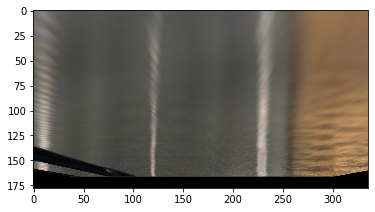

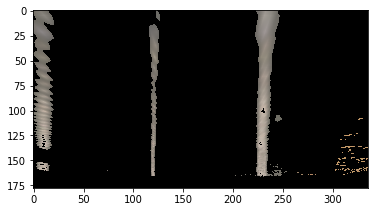

[190 191 191 ... 243 243 244] [0 0 0 ... 5 5 5]
[190 191 191 ... 243 243 244] [0 0 0 ... 5 5 5]
[190 191 191 ... 243 243 244] [0 0 0 ... 5 5 5]


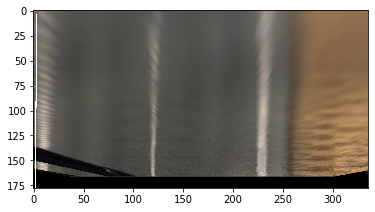

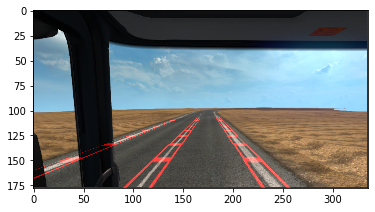

In [18]:
screen = cv2.imread('test2.png')
perspective_matrices = get_perspective_matrix(screen)
process(screen, perspective_matrices)